In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

2023-09-06 11:46:55.927263: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-06 11:46:56.739605: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
! nvidia-smi

Wed Sep  6 13:40:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
|  0%   23C    P8    11W / 275W |      2MiB / 11178MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import glob
instances=[np.load(result) for result in glob.glob('results/*.npy')]
instances =  np.array([instance[:,:92][1] for instance in instances])
df=pd.DataFrame(instances)
df

,0,1,2,3,4,5,6,7,8,9,...,82,83,84,85,86,87,88,89,90,91
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4095,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.000001,1.000005,1.000006,1.000003,0.999998,1.000001,0.999999,1.000001,1.0,1.0
4096,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.000001,1.000005,1.000006,1.000003,0.999998,1.000001,0.999999,1.000001,1.0,1.0
4097,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.000001,1.000005,1.000006,1.000003,0.999998,1.000001,0.999999,1.000001,1.0,1.0
4098,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.000001,1.000005,1.000006,1.000003,0.999998,1.000001,0.999999,1.000001,1.0,1.0


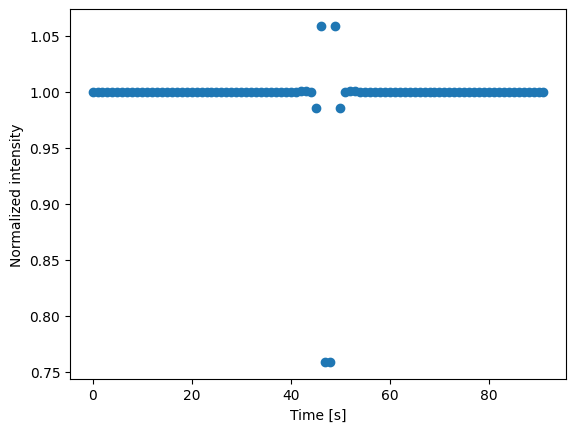

In [5]:
plt.xlabel('Time [s]')
plt.ylabel('Normalized intensity')
plt.plot(instances[0], 'o');

In [14]:
train_data,test_data = train_test_split(instances, test_size=0.2)

In [15]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [10]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])
    
    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(92, activation="sigmoid")])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()
autoencoder.compile(optimizer='adam', loss='mae')

2023-09-06 07:06:51.888896: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [11]:
autoencoder.save('results/autoencoder')

ValueError: Model <__main__.AnomalyDetector object at 0x7f2518afb3a0> cannot be saved either because the input shape is not available or because the forward pass of the model is not defined.To define a forward pass, please override `Model.call()`. To specify an input shape, either call `build(input_shape)` directly, or call the model on actual data using `Model()`, `Model.fit()`, or `Model.predict()`. If you have a custom training step, please make sure to invoke the forward pass in train step through `Model.__call__`, i.e. `model(inputs)`, as opposed to `model.call()`.

In [16]:
history = autoencoder.fit(train_data, train_data, 
          epochs=150, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/150
7/7 [==============================] - 12s 305ms/step - loss: 0.4486 - val_loss: 0.4362
Epoch 2/150
7/7 [==============================] - 0s 10ms/step - loss: 0.4222 - val_loss: 0.3971
Epoch 3/150
7/7 [==============================] - 0s 9ms/step - loss: 0.3727 - val_loss: 0.3297
Epoch 4/150
7/7 [==============================] - 0s 8ms/step - loss: 0.2948 - val_loss: 0.2372
Epoch 5/150
7/7 [==============================] - 0s 8ms/step - loss: 0.2000 - val_loss: 0.1437
Epoch 6/150
7/7 [==============================] - 0s 7ms/step - loss: 0.1168 - val_loss: 0.0790
Epoch 7/150
7/7 [==============================] - 0s 7ms/step - loss: 0.0655 - val_loss: 0.0483
Epoch 8/150
7/7 [==============================] - 0s 8ms/step - loss: 0.0458 - val_loss: 0.0412
Epoch 9/150
7/7 [==============================] - 0s 8ms/step - loss: 0.0424 - val_loss: 0.0407
Epoch 10/150
7/7 [==============================] - 0s 8ms/step - loss: 0.0417 - val_loss: 0.0395
Epoch 11/150
7/7 [=======

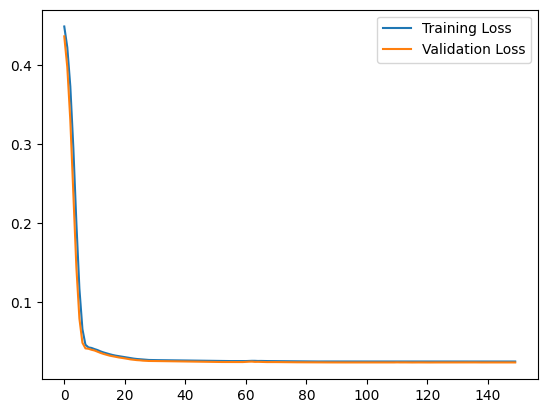

In [17]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

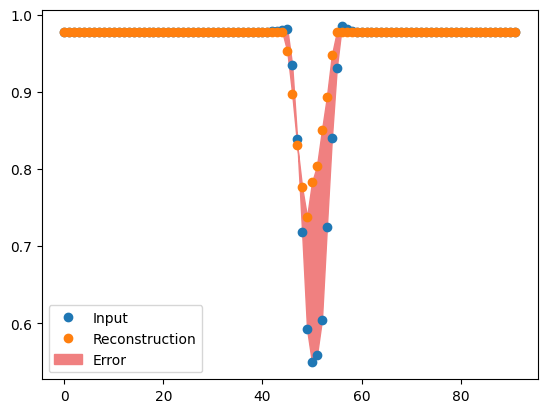

In [19]:
encoded_data = autoencoder.encoder(test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(test_data[0], 'o')
plt.plot(decoded_data[0], 'o')
plt.fill_between(np.arange(92), decoded_data[0], test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

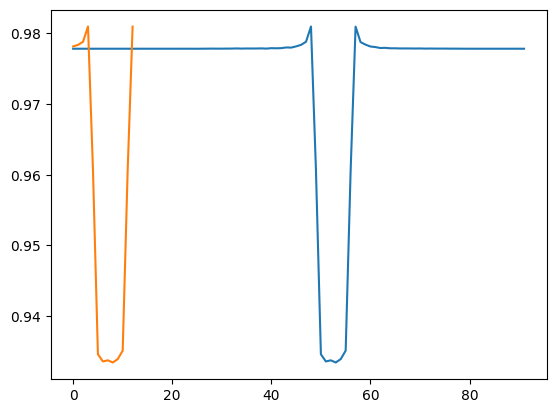

In [35]:
# and operation
def and_timeseries(decoded_data,original):
    result=tf.square(decoded_data - original).numpy()
    return original[result >= 0.000001]

index = 3
plt.plot(test_data[index])
plt.plot(and_timeseries(decoded_data[index], test_data[index]));
plt.show()

In [ ]:
def and_timeseries(x,y):
    reconstructions = autoencoder.predict(train_data)
    train_loss = tf.keras.losses.mae(reconstructions, train_data)

103/103 [==============================] - 0s 1ms/step


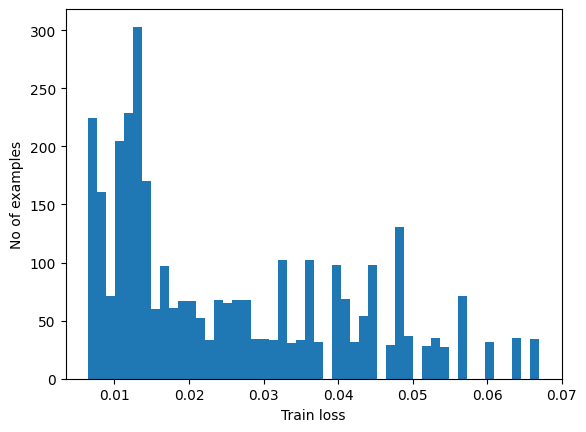

In [191]:
reconstructions = autoencoder.predict(train_data)
train_loss = tf.keras.losses.mae(reconstructions, train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [192]:
threshold = np.mean(train_loss) + np.std(train_loss)
threshold

0.041274022

In [202]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

predict(autoencoder, test_data[:1], threshold)

<tf.Tensor: shape=(1,), dtype=bool, numpy=array([ True])>

# Cluster problem

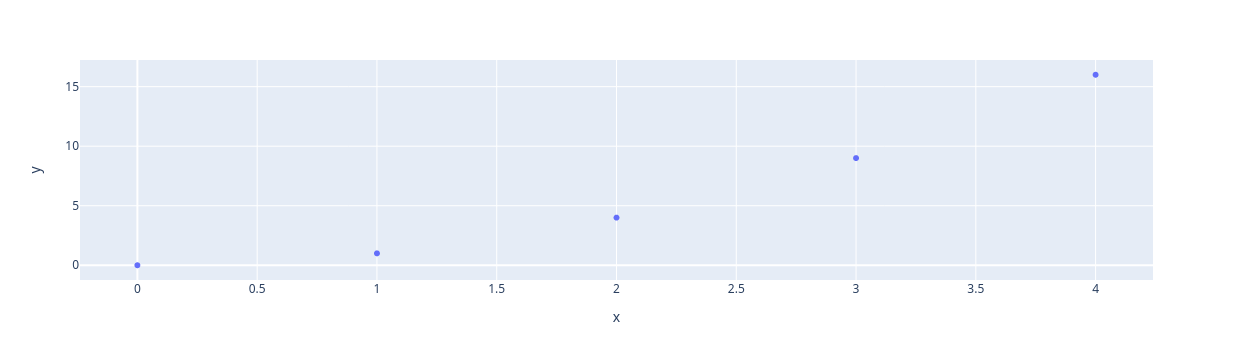

In [254]:
import plotly.express as px
fig = px.scatter(x=[0, 1, 2, 3, 4], y=[0, 1, 4, 9, 16])
fig.show()